# Pairs Trading Strategy

The implementations will follow:

@article{smith2017good,
  title={A good pair: alternative pairs-trading strategies},
  author={Smith, R Todd and Xu, Xun},
  journal={Financial Markets and Portfolio Management},
  volume={31},
  pages={1--26},
  year={2017},
  publisher={Springer}
}

---

The stocks used are random popular US Stocks, just to make an example

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [180]:
# Downloading adjusted closing prices for the following stocks
# Apple, Microsoft, Amazon, Google, Meta, Tesla, Berkshire Hathaway, JPMorgan Chase, Johnson & Johnson, Visa
symbols = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'Meta', 'TSLA', 'BRK-B', 'JPM', 'JNJ', 'V']

# symbols = ["HDFCBANK.NS", "ICICIBANK.NS", "AXISBANK.NS", "KOTAKBANK.NS", "INDUSINDBK.NS"]

data = yf.download(symbols, start="2022-01-01", end="2022-12-31")['Adj Close']

[*********************100%%**********************]  10 of 10 completed


## How the stocks will be picked

We will be testing two methods of picking stocks for the pairs trading - the distance method and the cointigration method.

### Data normalization

Firstly, in order to better compare the different stocks, we will normalize all the stocks to the same scale. We will be looking at their adjusted closing price, thus integrating all the splits and dividends into the stock price. To properly scale the stocks to a similar scale, we will initialize all the stocks to 1.0, and then the evolution for each stock, will be their daily returns for each day. This gives us the following formula:

$$ P_t^i = \prod_{\tau = 1}^t \left( 1 + r_{\tau}^i  \right), $$

where $T$ is the number of time periods in our data sample, and $r_{\tau}^i$ is the return for stock $i$ at time $\tau$ from time $\tau - 1$. This then gives us the normalized prices $P$ for each stock $i$, and its evolution at each time period $t$.

### The distance method

This method calculates the euclidian distance between time-series X and Y. This metric will tell us, how much these two time-series deviate from each other in the euclidean space. The distance between the two time-series is calculated as:

$$ D_{i, j} = \frac{\sum_{t=1}^T \left( P_t^i - P_t^j \right)^2}{T}. $$

This gives us a distance matrix of size $(N \times (N - 1))/2$, given there are $N$ stocks.

### The cointigration method



In [181]:
def PriceNormalization(data):
    '''
    Normalize the data, by aggregating the returns of the stocks, making them all start at 1.0

    Input:
    data: DataFrame with the stocks prices

    Output:
    data: DataFrame with the normalized prices
    '''

    # Initialize the DataFrame to store the normalized prices
    data_normalized = data.copy()

    for stock in data.columns:
        # Calculate the returns of the stock
        r_i = data[stock].pct_change()

        # Calculate the normalized price
        data_normalized[stock] = (1 + r_i).cumprod()

    return data_normalized.dropna()


def Distance(data):
    '''
    Calculate the distance between the normalized prices of the stocks

    Input:
    data: DataFrame with the normalized prices

    Output:
    distance: DataFrame with the distance between the normalized prices
    '''

    # Initialize the DataFrame to store the distances
    distance = pd.DataFrame(index=data.columns, columns=data.columns)

    for stock1 in data.columns:
        for stock2 in data.columns:
            if stock1 != stock2:
                # Calculate the distance between the normalized prices
                distance[stock1][stock2] = ((data[stock1] - data[stock2])**2).sum()/len(data[stock1])

    return distance


def Cointegration(data):
    '''
    Calculate the cointegration between the normalized prices of the stocks

    Input:
    data: DataFrame with the normalized prices

    Output:
    cointegration: DataFrame with the cointegration between the normalized prices
    '''

    # Initialize the DataFrame to store the cointegration
    cointegration = pd.DataFrame(index=data.columns, columns=data.columns)

    for stock1 in data.columns:
        for stock2 in data.columns:
            if stock1 != stock2:
                # Calculate the cointegration between the normalized prices
                cointegration[stock1][stock2] = coint(data[stock1], data[stock2])[1]

    return cointegration

In [182]:
data_norm = PriceNormalization(data)

In [183]:
data_distance = Distance(data_norm)

data_cointegration = Cointegration(data)

In [184]:
def find_best_pairs(data, threshold):
    '''
    Find the best pairs of stocks to trade

    Input:
    data: DataFrame with the matrix metric between the normalized prices
    threshold: float with the threshold for the pairs selection

    Output:
    pairs: list with the best pairs of stocks to trade
    '''

    pairs = []

    for stock1 in data.columns:
        for stock2 in data.columns:
            if stock1 != stock2:
                if data[stock1][stock2] < threshold:
                    pairs.append((stock1, stock2))

    if pairs == []:
        print('No pairs found with the given threshold')
    
    # Remove duplicates
    for pair in pairs:
        if (pair[1], pair[0]) in pairs:
            pairs.remove((pair[1], pair[0]))

    return pairs

In [190]:
best_pairs_dist = find_best_pairs(data_distance, 0.005)
best_pairs_coint = find_best_pairs(data_cointegration, 0.02)

In [245]:
# best_pairs = best_pairs_dist
best_pairs = best_pairs_coint

test_data = yf.download(best_pairs[0], start="2022-01-01", end="2022-12-31")['Adj Close']

[*********************100%%**********************]  2 of 2 completed


### Trade on the spread

The spread is the residual $\epsilon_t$ from the regression of $X$ onto $Y$:

$$\epsilon_t = Y_t - \beta_t X_t,$$

where

$Y_t$ is the dependend variable\
$X_t$ is the independend variable\
$\beta_t$ is the rolling hedge ratio

In [246]:
def rolling_beta(asset_1, asset_2, window):
    '''
    Calculate the beta between the normalized prices of the stocks using a rolling hedge.

    Input:
    data: DataFrame with the normalized prices (2 columns).
    window: int with the window size for the rolling hedge.

    Output:
    beta: Series with the beta between the normalized prices.
    '''
    beta_values = []

    for i in range(len(asset_1) - window + 1):
        # Get the rolling window for both stocks
        x_window = asset_1.iloc[i:i+window]
        y_window = asset_2.iloc[i:i+window]

        # # Perform OLS regression
        # model = sm.OLS(y_window, x_window).fit()

        # # Calculate the spread as the difference between actual and fitted values for the last data point in the window
        # spread = y_window.iloc[-1] - model.fittedvalues.iloc[-1]

        # Calculate the slope as the first order polynomial fit
        beta = np.polyfit(x_window, y_window, 1)[0]

        beta_values.append(beta)

    # Padding NaN for the initial periods
    beta_values = [np.nan] * (window - 1) + beta_values

    # Return as a pandas Series
    return pd.Series(beta_values, index=data.index)


In [247]:
test_data_norm = PriceNormalization(test_data)

In [248]:
window = 30
beta = rolling_beta(test_data[best_pairs[0][0]], test_data[best_pairs[0][1]], window)


# return the spread values
spread = test_data[best_pairs[0][1]] - beta * test_data[best_pairs[0][0]]

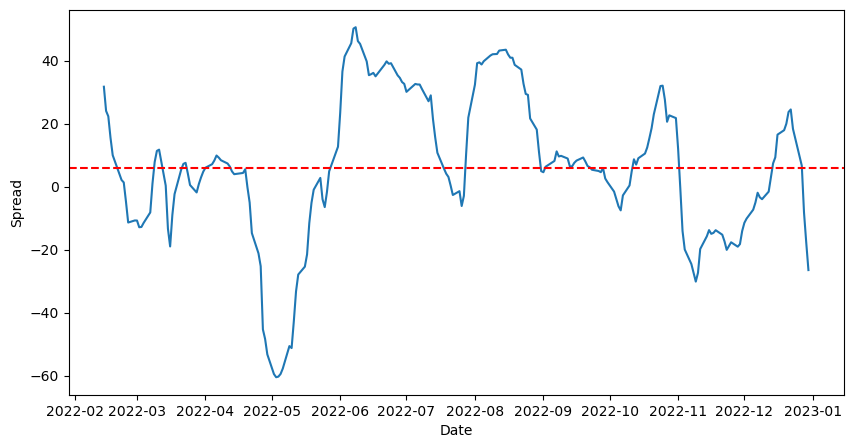

In [249]:
# Plot the spread around its mean

plt.figure(figsize=(10, 5))

plt.plot(spread.index, spread, label='Spread')
plt.axhline(spread.mean(), color='r', linestyle='--', label='Zero')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.show()

In [250]:
# Calculate the z-score of the spread
def z_score(spread, window):
    '''
    Calculate the z-score of the spread

    Input: The spread between the normalized prices of the stocks

    Output: The z-score of the spread
    '''

    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()

    z_score = (spread - rolling_mean) / rolling_std

    return z_score

In [251]:
z_score = z_score(spread, window)

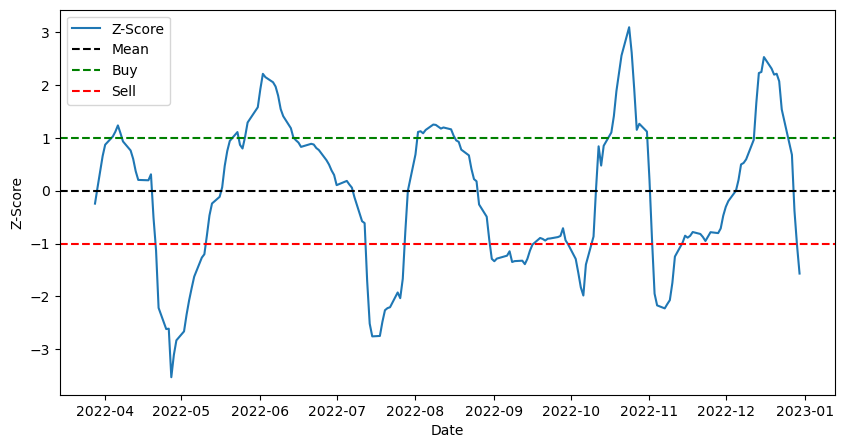

In [252]:
# Plot the z-score of the spread

plt.figure(figsize=(10, 5))

plt.plot(z_score.index, z_score, label='Z-Score')
plt.axhline(0, color='black', linestyle='--', label='Mean')
plt.axhline(1, color='g', linestyle='--', label='Buy')
plt.axhline(-1, color='r', linestyle='--', label='Sell')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()

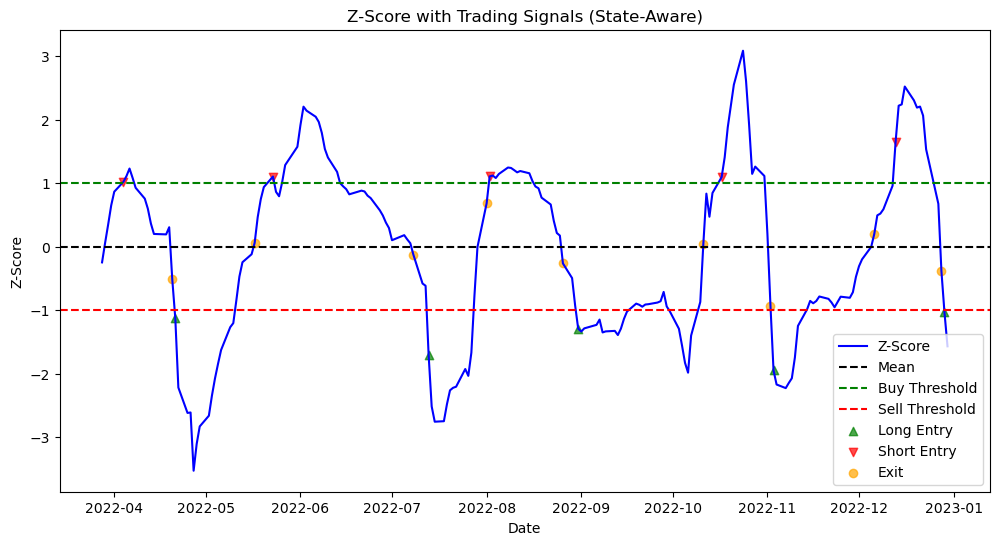

In [253]:
def calculate_signals_with_active_state(z_score, upper=1, lower=-1):
    '''
    Calculate the signals for entering and exiting trades while ensuring no overlapping positions.

    Input:
    z_score: Series of z-scores
    upper: Upper threshold for entering a short position (default=1)
    lower: Lower threshold for entering a long position (default=-1)

    Output:
    signals: DataFrame with entry and exit signals
    '''
    signals = pd.DataFrame(index=z_score.index)
    signals['z_score'] = z_score

    # Initialize columns for long/short entry and exit signals
    signals['long_entry'] = False
    signals['short_entry'] = False
    signals['exit'] = False

    # Track active position: 0 (no position), 1 (long), -1 (short)
    active_position = 0

    for i in range(1, len(z_score)):
        # Check for exit condition if a trade is active
        if active_position != 0:
            if z_score.iloc[i] * z_score.iloc[i - 1] <= 0:  # Crosses 0
                signals.loc[z_score.index[i], 'exit'] = True
                active_position = 0  # Reset active position

        # Check for long entry if no active position
        if active_position == 0 and z_score.iloc[i] < lower and z_score.iloc[i - 1] >= lower:
            signals.loc[z_score.index[i], 'long_entry'] = True
            active_position = 1  # Set active position to long

        # Check for short entry if no active position
        elif active_position == 0 and z_score.iloc[i] > upper and z_score.iloc[i - 1] <= upper:
            signals.loc[z_score.index[i], 'short_entry'] = True
            active_position = -1  # Set active position to short

    return signals

# Calculate signals with active state management
signals = calculate_signals_with_active_state(z_score, upper=1, lower=-1)

# Plot the z-score and signals
plt.figure(figsize=(12, 6))
plt.plot(z_score.index, z_score, label='Z-Score', color='blue')
plt.axhline(0, color='black', linestyle='--', label='Mean')
plt.axhline(1, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(-1, color='red', linestyle='--', label='Sell Threshold')

# Plot entry and exit points
plt.scatter(signals.index[signals['long_entry']], z_score[signals['long_entry']],
            color='green', label='Long Entry', marker='^', alpha=0.7)
plt.scatter(signals.index[signals['short_entry']], z_score[signals['short_entry']],
            color='red', label='Short Entry', marker='v', alpha=0.7)
plt.scatter(signals.index[signals['exit']], z_score[signals['exit']],
            color='orange', label='Exit', marker='o', alpha=0.7)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title('Z-Score with Trading Signals (State-Aware)')
plt.legend()
plt.show()


In [254]:
def calculate_signals_with_positions(z_score, buy_threshold=-1, sell_threshold=1, exit_above_zero=0, exit_below_zero=0):
    '''
    Calculate the signals for entering and exiting trades while ensuring no overlapping positions.

    Input:
    - z_score: Series of z-scores
    - buy_threshold: Threshold for entering a long position (default=-1)
    - sell_threshold: Threshold for entering a short position (default=1)
    - exit_above_zero: Threshold for exiting a long position (default=0)
    - exit_below_zero: Threshold for exiting a short position (default=0)

    Output:
    - signals: DataFrame with positions and entry/exit signals
    '''
    # Initialize signal tracking
    signals = pd.DataFrame(index=z_score.index)
    positions = []  # Tracks the position at each time step
    buy_signals = []  # Tracks indexes for buy signals
    sell_signals = []  # Tracks indexes for sell signals
    exit_signals = []  # Tracks indexes for exit signals

    # Track the current position: 0 (neutral), 1 (long), -1 (short)
    position = 0

    # Loop through the z-scores to generate signals
    for i, z in enumerate(z_score):
        if position == 0:  # Neutral position
            if z < buy_threshold:  # Buy signal (long position)
                position = 1
                buy_signals.append(i)
            elif z > sell_threshold:  # Sell signal (short position)
                position = -1
                sell_signals.append(i)
        elif position == 1:  # Long position
            if z > exit_above_zero:  # Exit long position
                position = 0
                exit_signals.append(i)
        elif position == -1:  # Short position
            if z < exit_below_zero:  # Exit short position
                position = 0
                exit_signals.append(i)
        
        positions.append(position)  # Append the current position

    # Add signals and positions to the DataFrame
    signals['Position'] = positions
    signals['Buy'] = z_score.index.isin(z_score.index[buy_signals])
    signals['Sell'] = z_score.index.isin(z_score.index[sell_signals])
    signals['Exit'] = z_score.index.isin(z_score.index[exit_signals])

    return signals


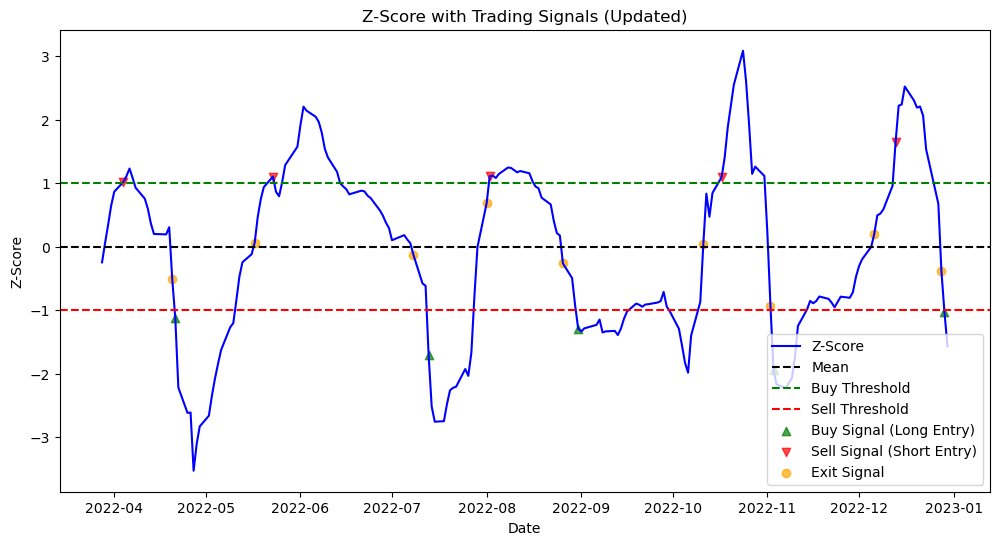

In [255]:
# Calculate signals with updated function
signals = calculate_signals_with_positions(z_score, buy_threshold=-1, sell_threshold=1, exit_above_zero=0, exit_below_zero=0)

# Plot the z-score and signals
plt.figure(figsize=(12, 6))
plt.plot(z_score.index, z_score, label='Z-Score', color='blue')
plt.axhline(0, color='black', linestyle='--', label='Mean')
plt.axhline(1, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(-1, color='red', linestyle='--', label='Sell Threshold')

# Plot entry and exit points
plt.scatter(signals.index[signals['Buy']], z_score[signals['Buy']],
            color='green', label='Buy Signal (Long Entry)', marker='^', alpha=0.7)
plt.scatter(signals.index[signals['Sell']], z_score[signals['Sell']],
            color='red', label='Sell Signal (Short Entry)', marker='v', alpha=0.7)
plt.scatter(signals.index[signals['Exit']], z_score[signals['Exit']],
            color='orange', label='Exit Signal', marker='o', alpha=0.7)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title('Z-Score with Trading Signals (Updated)')
plt.legend()
plt.show()


In [256]:
signals

,Position,Buy,Sell,Exit
Date,,,,
2022-01-03,0,False,False,False
2022-01-04,0,False,False,False
2022-01-05,0,False,False,False
2022-01-06,0,False,False,False
2022-01-07,0,False,False,False
...,...,...,...,...
2022-12-23,-1,False,False,False
2022-12-27,-1,False,False,False
2022-12-28,0,False,False,True


In [257]:
# Calculate the returns of the strategy

# Calculate the spread values
test_data['Spread'] = test_data[best_pairs[0][1]] - beta * test_data[best_pairs[0][0]]

# Calculate the spread returns
# test_data['Spread_Returns'] = test_data['Spread'].pct_change()
test_data['Spread_Returns'] = (test_data['Spread'] - test_data['Spread'].shift()) / (test_data[best_pairs[0][1]] + beta * test_data[best_pairs[0][0]])

# Compute the strategy returns based on the position signals
test_data['Strategy_Returns'] = signals['Position'].shift(1) * test_data['Spread_Returns']

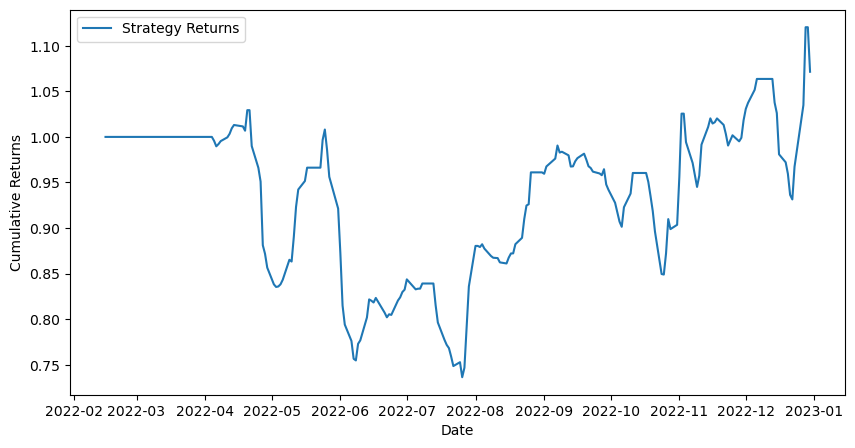

In [258]:
# Plot the strategy returns

test_data['cum_ret'] = (1 + test_data['Strategy_Returns']).cumprod()

plt.figure(figsize=(10, 5))

plt.plot(test_data['cum_ret'], label='Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [259]:
# Print total returns
total_returns = (test_data['cum_ret'].iloc[-1] - 1) * 100

print( "The total strategy returns are %.2f%%" % total_returns)

The total strategy returns are 7.15%


In [260]:
def calculate_strategy_performance(test_data, signals, beta, best_pairs, risk_free_rate=0.02):
    '''
    Calculate the strategy's performance metrics: total return, max drawdown, and Sharpe ratio.

    Inputs:
    - test_data: DataFrame with the price data of the two assets
    - signals: DataFrame with the position signals ('Position')
    - beta: Hedge ratio between the two assets
    - best_pairs: Tuple with the best cointegrated pair (column names in test_data)
    - risk_free_rate: Annualized risk-free rate for Sharpe ratio calculation (default=0.02)

    Outputs:
    - metrics: Dictionary containing total return, max drawdown, and Sharpe ratio
    - test_data: Updated DataFrame with calculated spread, spread returns, and strategy returns
    '''

    # Calculate the spread values
    test_data['Spread'] = test_data[best_pairs[0][1]] - beta * test_data[best_pairs[0][0]]

    # Calculate the spread returns
    test_data['Spread_Returns'] = (test_data['Spread'] - test_data['Spread'].shift()) / \
                                  (test_data[best_pairs[0][1]] + beta * test_data[best_pairs[0][0]])

    # Compute the strategy returns based on the position signals
    test_data['Strategy_Returns'] = signals['Position'].shift(1) * test_data['Spread_Returns']

    # Calculate cumulative returns
    test_data['cum_ret'] = (1 + test_data['Strategy_Returns']).cumprod()

    # Total Return
    total_return = (test_data['cum_ret'].iloc[-1] - 1) * 100

    # Max Drawdown
    rolling_max = test_data['cum_ret'].cummax()
    drawdown = test_data['cum_ret'] / rolling_max - 1
    max_drawdown = drawdown.min() * 100

    # Sharpe Ratio
    daily_return_mean = test_data['Strategy_Returns'].mean()
    daily_return_std = test_data['Strategy_Returns'].std()
    sharpe_ratio = (daily_return_mean - (risk_free_rate / 252)) / daily_return_std * np.sqrt(252)

    # Compile metrics
    metrics = {
        'Total Return (%)': total_return,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio': sharpe_ratio
    }

    return metrics, test_data


Performance Metrics:
Total Return (%): 7.15
Max Drawdown (%): -28.47
Sharpe Ratio: 0.34


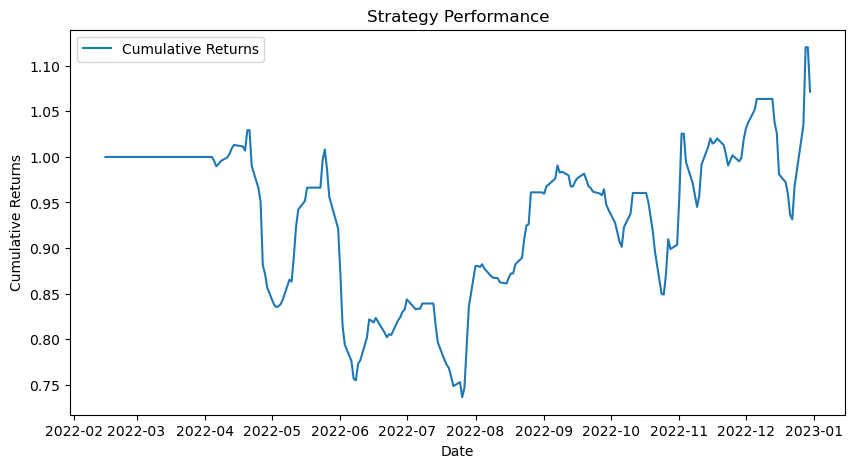

In [261]:
# Assume test_data and signals are pre-defined
metrics, updated_test_data = calculate_strategy_performance(test_data, signals, beta, best_pairs)

# Print metrics
print("Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

# Plot cumulative returns
plt.figure(figsize=(10, 5))
plt.plot(updated_test_data['cum_ret'], label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title('Strategy Performance')
plt.show()
